<a href="https://colab.research.google.com/github/zongseung/hyperPnL_Card/blob/main/candle_chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# 코인 및 시간 데이터를 받는 함수
# 스팟 - 현물이랑은 크게 차이가 없지 않나?

import numpy as np
import pandas as pd
import json
import requests

def candle_chart(interval):
# 현재 시간 설정
  current_time = int(pd.Timestamp.now().timestamp() * 1000)  # 현재 시간
  end_time = current_time  # 현재 시간

  api_url = "https://api.hyperliquid.xyz/info"

  body_candles = {
    "type": "candleSnapshot",
    "req": {
        "coin": "@107",  # 코인을 @107으로 설정 -> Hype의 명칭임
        "interval": interval,  # 하루 단위
        "startTime": 0,
        "endTime": end_time
    }
  }

  headers = {"Content-Type": "application/json"}

  response_candles = requests.post(api_url, headers=headers, json=body_candles)

  if response_candles.status_code == 200:
    print("API 요청 성공, 데이터 파싱 중...")

    # 캔들 데이터 파싱
    candles = response_candles.json()
    df_candles = pd.DataFrame(candles)
    df_candles['t'] = pd.to_datetime(df_candles['t'], unit='ms')  # 시간 변환
    df_candles.set_index('t', inplace=True)
    df_candles = df_candles.rename(columns={
        "o": "Open",
        "h": "High",
        "l": "Low",
        "c": "Close",
        "v": "Volume",
        "n" : "total_transaction"
    })

    # 문자열 데이터를 float로 변환
    numeric_columns = ["Open", "High", "Low", "Close", "Volume"]
    df_candles[numeric_columns] = df_candles[numeric_columns].astype(float)

    print("캔들 데이터 준비 완료")

    df_candles.drop(["T", "s", "i"], axis=1, inplace=True)

    return df_candles

# 해당 함수는 hypurrqaunt_candle_data import candle_chart로 명명한다.

In [3]:
# 시간별로 데이터를 뽑을 수 있음
df_minute = candle_chart("1m") # 1분 단위
df_hourly = candle_chart("1h") # 1시간 단위
df_daily = candle_chart("1d") # 일일 단위

API 요청 성공, 데이터 파싱 중...
캔들 데이터 준비 완료
API 요청 성공, 데이터 파싱 중...
캔들 데이터 준비 완료
API 요청 성공, 데이터 파싱 중...
캔들 데이터 준비 완료


In [190]:
# from hypurrquant.preprocessing import

def split_data(df, Type):
    '''
    데이터셋을 70:15:15 (Train:Validation:Test) 비율로 분할하는 함수.
    종가(Close)를 예측 대상으로 설정.
    '''
    input_data = df.drop(Type, axis=1)  # 입력 변수
    target_data = df[Type].values.reshape(-1, 1)  # 종가 (예측 대상)

    # 데이터 분할 (70% Train, 15% Validation, 15% Test)
    train_size = int(0.7 * len(df))
    val_size = int(0.15 * len(df))

    X_train, X_val, X_test = input_data.iloc[:train_size], input_data.iloc[train_size:train_size+val_size], input_data.iloc[train_size+val_size:]
    Y_train, Y_val, Y_test = target_data[:train_size], target_data[train_size:train_size+val_size], target_data[train_size+val_size:]

    return X_train, X_val, X_test, Y_train, Y_val, Y_test, input_data

def normalize_data(X_train, X_val, X_test, Y_train, Y_val, Y_test):
    '''
    MinMaxScaler를 사용하여 X (입력 데이터)와 Y (타겟 데이터)를 0~1 범위로 정규화하는 함수.
    '''
    from sklearn.preprocessing import MinMaxScaler

    X_scaler = MinMaxScaler()
    X_train_scaled = X_scaler.fit_transform(X_train)
    X_val_scaled = X_scaler.transform(X_val)
    X_test_scaled = X_scaler.transform(X_test)


    Y_scaler = MinMaxScaler()
    Y_train_scaled = Y_scaler.fit_transform(Y_train)
    Y_val_scaled = Y_scaler.transform(Y_val)
    Y_test_scaled = Y_scaler.transform(Y_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled, X_scaler, Y_scaler


### AI 기반 예측 코드 생성

In [191]:
def create_sequences(X, Y, seq_length=10):
    '''
    LSTM 모델 학습을 위해 데이터를 (samples, time_steps, features) 형태로 변환.
    seq_length: 사용할 시퀀스 길이 (기본값 10)

    # 여기서 시간단위는 24로 슬라이딩 윈도우
    '''
    sequences, targets = [], []

    for i in range(len(X) - seq_length):
        sequences.append(X[i:i+seq_length])
        targets.append(Y[i+seq_length])

    return np.array(sequences), np.array(targets)


In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from torch.nn import Transformer
from torch.utils.data import DataLoader, TensorDataset

# json
import json
import requests
class LSTM(nn.Module):
    def __init__(self, lstm_layers, dense_layers, units, dense_units, lstm_dropout_rate, dense_dropout_rate, input_features):
        super(LSTM, self).__init__()
        # num_layers가 1이면 dropout을 0으로 설정
        lstm_dropout_rate = 0 if lstm_layers == 1 else lstm_dropout_rate

        # LSTM 레이어
        self.lstm = nn.LSTM(input_size=input_features, hidden_size=units, num_layers=lstm_layers, dropout=lstm_dropout_rate, batch_first=True)

        # Dense 레이어
        self.dense_layers = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(units if i == 0 else dense_units, dense_units),
                nn.ReLU(),
                nn.Dropout(dense_dropout_rate)
            ) for i in range(dense_layers)]
        )
        # 출력 레이어
        self.output_layer = nn.Linear(dense_units if dense_layers > 0 else units, 1)

    def forward(self, x):
        x, _ = self.lstm(x)  # LSTM 적용
        x = x[:, -1, :]  # 마지막 타임스텝 출력 사용
        for layer in self.dense_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

# DataLoader 생성 함수
def create_dataloader(X, Y, batch_size):
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Fitness 함수
def fitness_function(params, X_train, Y_train, X_val, Y_val, device):
    lstm_layers, dense_layers, units, dense_units, learning_rate, lstm_dropout_rate, dense_dropout_rate, batch_size = (
        int(params[0]), int(params[1]), int(params[2]), int(params[3]), params[4], params[5], params[6], int(params[7])
    )
    # LSTM 모델 생성
    input_features = X_train.shape[2]
    model = LSTM(
        lstm_layers=lstm_layers,
        dense_layers=dense_layers,
        units=units,
        dense_units=dense_units,
        lstm_dropout_rate=lstm_dropout_rate,
        dense_dropout_rate=dense_dropout_rate,
        input_features=input_features
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # DataLoader 생성
    train_loader = create_dataloader(X_train, Y_train, batch_size)

    # 모델 학습
    model.train()
    for epoch in range(50):  # 간단히 50 Epoch로 설정
        for batch_X, batch_Y in train_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_Y)
            loss.backward()
            optimizer.step()

    # 검증 손실 계산
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32).to(device)
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, Y_val_tensor).item()

    return val_loss

def DBO_LSTM_with_obstacle(X_train, Y_train, X_val, Y_val, num_beetles=5, max_iter=10, device='cuda'):
    # 입력 파라미터 타입 확인 및 검증
    num_beetles = int(num_beetles)  # 정수형으로 변환
    max_iter = int(max_iter)        # 정수형으로 변환

    # 이제 스칼라 값으로 비교 가능
    if not isinstance(num_beetles, (int, np.integer)) or num_beetles < 1:
        raise ValueError("Number of beetles must be at least 1")
    if not isinstance(max_iter, (int, np.integer)) or max_iter < 1:
        raise ValueError("Maximum iterations must be at least 1")

    # Bounds 배열의 타입 명시
    bounds = [
        np.array([1.0, 2.0, 10.0, 100.0, 0.0001, 0.1, 0.1, 8], dtype=float),
        np.array([2.0, 3.0, 100.0, 300.0, 0.01, 0.5, 0.5, 256.0], dtype=float)
    ]

    # bounds 검증
    if len(bounds[0]) != len(bounds[1]):
        raise ValueError("Upper and lower bounds must have same dimension")
    if np.any(bounds[0] > bounds[1]):  # any() 사용하여 배열 비교
        raise ValueError("Lower bounds must be less than upper bounds")

    # 초기 위치 생성 수정
    positions = np.zeros((num_beetles, len(bounds[0])))
    for i in range(len(bounds[0])):
        positions[:, i] = np.random.uniform(
            low=bounds[0][i],
            high=bounds[1][i],
            size=num_beetles
        )
    previous_positions = positions.copy()

    # 초기 fitness 계산
    fitness_values = [fitness_function(pos, X_train, Y_train, X_val, Y_val, device) for pos in positions]
    best_position = positions[np.argmin(fitness_values)]
    worst_position = positions[np.argmax(fitness_values)]
    best_fitness = np.min(fitness_values)

    k, b, S = 0.1, 0.3, 0.5  # 알고리즘 상수
    best_fitness_history = []  # fitness 기록 추가

    for t in range(max_iter):
        R = 1 - t / max_iter

        for i in range(num_beetles):
            obstacle = np.random.choice([True, False], p=[0.2, 0.8])

            if obstacle:
                theta = np.random.uniform(0, np.pi)
                positions[i] += np.tan(theta) * np.abs(positions[i] - previous_positions[i])
            else:
                delta_x = np.abs(positions[i] - worst_position)
                alpha = np.random.choice([-1, 1])
                positions[i] += alpha * k * (positions[i] - previous_positions[i]) + b * delta_x

            Lb_star = np.maximum(best_position * (1 - R), bounds[0])
            Ub_star = np.minimum(best_position * (1 + R), bounds[1])

            b1, b2 = np.random.uniform(0, 1, size=positions[i].shape), np.random.uniform(0, 1, size=positions[i].shape)
            egg_position = best_position + b1 * (positions[i] - Lb_star) + b2 * (positions[i] - Ub_star)

            Lbb = np.maximum(best_position * (1 - R), bounds[0])
            Ubb = np.minimum(best_position * (1 + R), bounds[1])

            C1, C2 = np.random.normal(0, 1, size=positions[i].shape), np.random.uniform(0, 1, size=positions[i].shape)
            foraging_position = positions[i] + C1 * (positions[i] - Lbb) + C2 * (positions[i] - Ubb)

            g = np.random.normal(0, 1, size=positions[i].shape)
            thief_position = best_position + S * g * (np.abs(positions[i] - best_position) + np.abs(positions[i] - best_position))

            positions[i] = (egg_position + thief_position) / 2
            positions[i] = np.clip(positions[i], bounds[0], bounds[1])

        previous_positions = positions.copy()

        fitness_values = [fitness_function(pos, X_train, Y_train, X_val, Y_val, device) for pos in positions]
        min_idx = np.argmin(fitness_values)
        max_idx = np.argmax(fitness_values)

        if fitness_values[min_idx] < best_fitness:
            best_fitness = fitness_values[min_idx]
            best_position = positions[min_idx]
        worst_position = positions[max_idx]

        best_fitness_history.append(best_fitness)

        # Early stopping 체크 추가
        if t >= 5:  # 최소 5회 이상 반복 후
            recent_improvement = best_fitness_history[-6] - best_fitness_history[-1]
            if recent_improvement < 1e-4:  # 개선이 매우 작은 경우
                print(f"Early stopping at iteration {t + 1} due to lack of improvement")
                break

        print(f"Iteration {t + 1}, Best Fitness: {best_fitness:.4f}, Best Position: {best_position}")

    return best_position

# 모델 학습 함수
def train_model(X_train, Y_train, X_val, Y_val, X_test, Y_test, params, device):
    lstm_layers, dense_layers, units, dense_units, learning_rate, lstm_dropout_rate, dense_dropout_rate, batch_size = params
    input_features = X_train.shape[2]

    model = LSTM(
        lstm_layers=int(lstm_layers),
        dense_layers=int(dense_layers),
        units=int(units),
        dense_units=int(dense_units),
        lstm_dropout_rate=lstm_dropout_rate,
        dense_dropout_rate=dense_dropout_rate,
        input_features=input_features
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # DataLoader 생성
    train_loader = create_dataloader(X_train, Y_train, int(batch_size))
    val_loader = create_dataloader(X_val, Y_val, int(batch_size))

    model.train()
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(200), desc="Training Progress"):
        epoch_train_loss = 0
        model.train()
        for batch_X, batch_Y in train_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            optimizer.zero_grad()
            predictions = model(batch_X)
            train_loss = criterion(predictions, batch_Y)
            train_loss.backward()
            optimizer.step()
            epoch_train_loss += train_loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation loss 계산
        epoch_val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch_X, batch_Y in val_loader:
                batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
                predictions = model(batch_X)
                val_loss = criterion(predictions, batch_Y)
                epoch_val_loss += val_loss.item()
        val_losses.append(epoch_val_loss / len(val_loader))

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/1000], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    print("Model training complete.")

    model.eval()
    with torch.no_grad():
        if isinstance(X_test, pd.DataFrame):
            X_test = X_test.values

        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        test_predictions = model(X_test_tensor).cpu().numpy()

    return model, test_predictions, train_losses, val_losses

def enable_dropout(model):
    """
    모델의 Dropout 레이어를 학습 모드로 설정 (MC Dropout 활성화)
    """
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            module.train()  # Dropout 활성화

def predict_with_ci(model, X_test, device, mc_samples=100):
    """
    신뢰구간을 포함한 예측 수행 (MC Dropout 적용)

    Args:
        model: 학습된 LSTM 모델
        X_test: 예측할 데이터 (numpy or DataFrame)
        device: GPU 또는 CPU
        mc_samples: Monte Carlo 샘플링 횟수 (기본 100회)

    Returns:
        mean_predictions: 예측값 평균
        lower_bounds: 신뢰구간 하한 (95%)
        upper_bounds: 신뢰구간 상한 (95%)
    """
    model.eval()  # 평가 모드
    enable_dropout(model)  # MC Dropout 활성화

    # 데이터가 DataFrame이면 numpy 배열로 변환
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    mc_preds = []

    with torch.no_grad():
        for _ in range(mc_samples):  # MC Dropout을 통해 여러 번 예측
            predictions = model(X_test_tensor)
            mc_preds.append(predictions.cpu().numpy().flatten())

    mc_preds = np.array(mc_preds)  # (mc_samples, batch_size)
    mean_predictions = np.mean(mc_preds, axis=0)  # 평균 예측값
    std_predictions = np.std(mc_preds, axis=0)  # 표준편차 계산

    ci_lower = mean_predictions - 1.96 * std_predictions  # 95% 신뢰구간 하한
    ci_upper = mean_predictions + 1.96 * std_predictions  # 95% 신뢰구간 상한

    return mean_predictions, ci_lower, ci_upper

In [197]:
features = ["Close", "Open", "High", "Low", "Volume", "total_transaction"]
seq_length = 24  # 시퀀스 길이 설정

data_dict = {}  # 각 변수를 저장할 딕셔너리

for feature in features:
    print(f"\n🚀 Processing: {feature}")

    # 데이터 분할
    X_train, X_val, X_test, Y_train, Y_val, Y_test, index_data = split_data(df_hourly, feature)

    # 데이터 정규화
    X_train_scaled, X_val_scaled, X_test_scaled, Y_train_scaled, Y_val_scaled, Y_test_scaled, X_scaler, Y_scaler = normalize_data(
        X_train, X_val, X_test, Y_train, Y_val, Y_test
    )

    # 시퀀스 데이터 생성
    X_train_seq, Y_train_seq = create_sequences(X_train_scaled, Y_train_scaled, seq_length)
    X_val_seq, Y_val_seq = create_sequences(X_val_scaled, Y_val_scaled, seq_length)
    X_test_seq, Y_test_seq = create_sequences(X_test_scaled, Y_test_scaled, seq_length)

    # 데이터 저장
    data_dict[feature] = {
        "X_train_seq": X_train_seq, "Y_train_seq": Y_train_seq,
        "X_val_seq": X_val_seq, "Y_val_seq": Y_val_seq,
        "X_test_seq": X_test_seq, "Y_test_seq": Y_test_seq,
        "X_scaler": X_scaler, "Y_scaler": Y_scaler
    }

    # 데이터 형태 출력
    print(f"✅ {feature} - X_train shape: {X_train_seq.shape}, Y_train shape: {Y_train_seq.shape}")
    print(f"✅ {feature} - X_val shape: {X_val_seq.shape}, Y_val shape: {Y_val_seq.shape}")
    print(f"✅ {feature} - X_test shape: {X_test_seq.shape}, Y_test shape: {Y_test_seq.shape}") # 1526+308+309


🚀 Processing: Close
✅ Close - X_train shape: (1526, 24, 5), Y_train shape: (1526, 1)
✅ Close - X_val shape: (308, 24, 5), Y_val shape: (308, 1)
✅ Close - X_test shape: (309, 24, 5), Y_test shape: (309, 1)

🚀 Processing: Open
✅ Open - X_train shape: (1526, 24, 5), Y_train shape: (1526, 1)
✅ Open - X_val shape: (308, 24, 5), Y_val shape: (308, 1)
✅ Open - X_test shape: (309, 24, 5), Y_test shape: (309, 1)

🚀 Processing: High
✅ High - X_train shape: (1526, 24, 5), Y_train shape: (1526, 1)
✅ High - X_val shape: (308, 24, 5), Y_val shape: (308, 1)
✅ High - X_test shape: (309, 24, 5), Y_test shape: (309, 1)

🚀 Processing: Low
✅ Low - X_train shape: (1526, 24, 5), Y_train shape: (1526, 1)
✅ Low - X_val shape: (308, 24, 5), Y_val shape: (308, 1)
✅ Low - X_test shape: (309, 24, 5), Y_test shape: (309, 1)

🚀 Processing: Volume
✅ Volume - X_train shape: (1526, 24, 5), Y_train shape: (1526, 1)
✅ Volume - X_val shape: (308, 24, 5), Y_val shape: (308, 1)
✅ Volume - X_test shape: (309, 24, 5), Y_tes

In [254]:
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 예측 대상 변수 리스트 (Close, Open, High, Low, Volume, 거래량)
    target_features = ["Close", "Open", "High", "Low", "Volume", "total_transaction"]

    models = {}  # 학습된 모델 저장
    best_params_dict = {}  # 최적 하이퍼파라미터 저장
    predictions_dict = {}  # 예측값 저장

    for feature in target_features:
        print(f"\n 하이퍼파라미터 최적화 시작: {feature}")


        best_params = DBO_LSTM_with_obstacle(
            data_dict[feature]["X_train_seq"], data_dict[feature]["Y_train_seq"],
            data_dict[feature]["X_val_seq"], data_dict[feature]["Y_val_seq"],
            num_beetles=5, max_iter=5, device=device
        )
        best_params_dict[feature] = best_params
        print(f"최적 하이퍼파라미터 ({feature}): {best_params}")

        # LSTM 모델 학습
        model, predictions, train_losses, val_losses = train_model(
            data_dict[feature]["X_train_seq"], data_dict[feature]["Y_train_seq"],
            data_dict[feature]["X_val_seq"], data_dict[feature]["Y_val_seq"],
            data_dict[feature]["X_test_seq"], data_dict[feature]["Y_test_seq"],
            best_params, device
        )

        # 학습된 모델 및 예측값 저장
        models[feature] = model
        predictions_dict[feature] = predictions

        print(f"{feature} 예측 완료")

    print("Model complete !")


 하이퍼파라미터 최적화 시작: Close
Iteration 1, Best Fitness: 0.0003, Best Position: [1.00000000e+00 2.39693578e+00 4.57068477e+01 1.00000000e+02
 1.34030086e-03 4.96168700e-01 1.34426631e-01 1.71993232e+02]
Iteration 2, Best Fitness: 0.0003, Best Position: [1.00000000e+00 2.49961352e+00 4.36874928e+01 1.00000000e+02
 2.41990925e-03 5.00000000e-01 1.95294281e-01 2.17982387e+02]
Iteration 3, Best Fitness: 0.0003, Best Position: [1.00000000e+00 2.45977093e+00 5.78914050e+01 1.00000000e+02
 4.93756610e-03 5.00000000e-01 2.02337950e-01 2.56000000e+02]
Iteration 4, Best Fitness: 0.0003, Best Position: [1.00000000e+00 2.56411396e+00 5.59707172e+01 1.00000000e+02
 4.55327962e-03 5.00000000e-01 1.41026755e-01 2.56000000e+02]
Iteration 5, Best Fitness: 0.0003, Best Position: [1.00000000e+00 2.66820281e+00 5.94082459e+01 1.00000000e+02
 4.70171365e-03 5.00000000e-01 1.63251792e-01 2.56000000e+02]
최적 하이퍼파라미터 (Close): [1.00000000e+00 2.66820281e+00 5.94082459e+01 1.00000000e+02
 4.70171365e-03 5.00000000e-01

Training Progress:   8%|▊         | 16/200 [00:00<00:05, 32.46it/s]

Epoch [10/1000], Train Loss: 0.0053, Val Loss: 0.0014


Training Progress:  12%|█▏        | 24/200 [00:00<00:05, 32.69it/s]

Epoch [20/1000], Train Loss: 0.0037, Val Loss: 0.0004


Training Progress:  18%|█▊        | 36/200 [00:01<00:05, 32.63it/s]

Epoch [30/1000], Train Loss: 0.0033, Val Loss: 0.0003


Training Progress:  22%|██▏       | 43/200 [00:01<00:05, 26.39it/s]

Epoch [40/1000], Train Loss: 0.0027, Val Loss: 0.0004


Training Progress:  26%|██▌       | 52/200 [00:01<00:06, 24.56it/s]

Epoch [50/1000], Train Loss: 0.0027, Val Loss: 0.0004


Training Progress:  32%|███▏      | 64/200 [00:02<00:05, 23.60it/s]

Epoch [60/1000], Train Loss: 0.0025, Val Loss: 0.0005


Training Progress:  36%|███▋      | 73/200 [00:02<00:05, 23.14it/s]

Epoch [70/1000], Train Loss: 0.0025, Val Loss: 0.0002


Training Progress:  42%|████▎     | 85/200 [00:03<00:04, 23.52it/s]

Epoch [80/1000], Train Loss: 0.0022, Val Loss: 0.0010


Training Progress:  48%|████▊     | 96/200 [00:03<00:03, 28.83it/s]

Epoch [90/1000], Train Loss: 0.0020, Val Loss: 0.0004


Training Progress:  52%|█████▏    | 104/200 [00:03<00:03, 31.13it/s]

Epoch [100/1000], Train Loss: 0.0019, Val Loss: 0.0002


Training Progress:  58%|█████▊    | 116/200 [00:04<00:02, 32.46it/s]

Epoch [110/1000], Train Loss: 0.0019, Val Loss: 0.0003


Training Progress:  62%|██████▏   | 124/200 [00:04<00:02, 32.48it/s]

Epoch [120/1000], Train Loss: 0.0015, Val Loss: 0.0003


Training Progress:  68%|██████▊   | 136/200 [00:04<00:01, 33.24it/s]

Epoch [130/1000], Train Loss: 0.0015, Val Loss: 0.0002


Training Progress:  72%|███████▏  | 144/200 [00:05<00:01, 32.72it/s]

Epoch [140/1000], Train Loss: 0.0014, Val Loss: 0.0002


Training Progress:  78%|███████▊  | 156/200 [00:05<00:01, 32.35it/s]

Epoch [150/1000], Train Loss: 0.0014, Val Loss: 0.0004


Training Progress:  82%|████████▏ | 164/200 [00:05<00:01, 32.85it/s]

Epoch [160/1000], Train Loss: 0.0015, Val Loss: 0.0003


Training Progress:  88%|████████▊ | 176/200 [00:06<00:00, 32.83it/s]

Epoch [170/1000], Train Loss: 0.0014, Val Loss: 0.0005


Training Progress:  92%|█████████▏| 184/200 [00:06<00:00, 33.09it/s]

Epoch [180/1000], Train Loss: 0.0013, Val Loss: 0.0004


Training Progress:  98%|█████████▊| 196/200 [00:06<00:00, 32.76it/s]

Epoch [190/1000], Train Loss: 0.0012, Val Loss: 0.0002


Training Progress: 100%|██████████| 200/200 [00:06<00:00, 29.56it/s]


Epoch [200/1000], Train Loss: 0.0012, Val Loss: 0.0002
Model training complete.
Close 예측 완료

 하이퍼파라미터 최적화 시작: Open
Iteration 1, Best Fitness: 0.0001, Best Position: [1.54360802e+00 2.62948319e+00 1.00000000e+02 1.54483893e+02
 7.40395388e-03 2.18210124e-01 2.31406203e-01 7.21220721e+01]
Iteration 2, Best Fitness: 0.0000, Best Position: [1.77821809e+00 2.81878866e+00 1.00000000e+02 1.60730833e+02
 7.95979418e-03 2.44588032e-01 2.21713893e-01 6.59260339e+01]
Iteration 3, Best Fitness: 0.0000, Best Position: [1.84660322e+00 3.00000000e+00 1.00000000e+02 1.69822977e+02
 7.45549432e-03 2.68376762e-01 2.27557674e-01 7.67898713e+01]
Iteration 4, Best Fitness: 0.0000, Best Position: [2.00000000e+00 3.00000000e+00 1.00000000e+02 1.50048347e+02
 8.46002840e-03 2.54425605e-01 2.40573140e-01 8.31199657e+01]
Iteration 5, Best Fitness: 0.0000, Best Position: [2.00000000e+00 3.00000000e+00 1.00000000e+02 1.54965986e+02
 8.99591081e-03 2.42416317e-01 2.32534749e-01 7.90278672e+01]
최적 하이퍼파라미터 (Open): [

Training Progress:   6%|▌         | 12/200 [00:01<00:16, 11.71it/s]

Epoch [10/1000], Train Loss: 0.0062, Val Loss: 0.0061


Training Progress:  11%|█         | 22/200 [00:01<00:15, 11.46it/s]

Epoch [20/1000], Train Loss: 0.0035, Val Loss: 0.0012


Training Progress:  15%|█▌        | 30/200 [00:02<00:17,  9.81it/s]

Epoch [30/1000], Train Loss: 0.0025, Val Loss: 0.0010


Training Progress:  20%|██        | 41/200 [00:04<00:20,  7.83it/s]

Epoch [40/1000], Train Loss: 0.0024, Val Loss: 0.0016


Training Progress:  26%|██▌       | 51/200 [00:05<00:14, 10.54it/s]

Epoch [50/1000], Train Loss: 0.0021, Val Loss: 0.0021


Training Progress:  30%|███       | 61/200 [00:05<00:12, 11.49it/s]

Epoch [60/1000], Train Loss: 0.0017, Val Loss: 0.0010


Training Progress:  36%|███▌      | 71/200 [00:06<00:11, 11.56it/s]

Epoch [70/1000], Train Loss: 0.0015, Val Loss: 0.0001


Training Progress:  40%|████      | 81/200 [00:07<00:10, 11.76it/s]

Epoch [80/1000], Train Loss: 0.0013, Val Loss: 0.0024


Training Progress:  46%|████▌     | 91/200 [00:08<00:09, 11.55it/s]

Epoch [90/1000], Train Loss: 0.0012, Val Loss: 0.0005


Training Progress:  50%|█████     | 101/200 [00:09<00:08, 11.38it/s]

Epoch [100/1000], Train Loss: 0.0012, Val Loss: 0.0002


Training Progress:  56%|█████▌    | 111/200 [00:10<00:07, 11.40it/s]

Epoch [110/1000], Train Loss: 0.0010, Val Loss: 0.0004


Training Progress:  60%|██████    | 121/200 [00:11<00:06, 11.41it/s]

Epoch [120/1000], Train Loss: 0.0013, Val Loss: 0.0002


Training Progress:  66%|██████▌   | 131/200 [00:11<00:05, 11.57it/s]

Epoch [130/1000], Train Loss: 0.0010, Val Loss: 0.0001


Training Progress:  70%|███████   | 141/200 [00:12<00:05, 11.54it/s]

Epoch [140/1000], Train Loss: 0.0009, Val Loss: 0.0001


Training Progress:  76%|███████▌  | 151/200 [00:13<00:04, 11.49it/s]

Epoch [150/1000], Train Loss: 0.0008, Val Loss: 0.0001


Training Progress:  80%|████████  | 161/200 [00:14<00:03,  9.92it/s]

Epoch [160/1000], Train Loss: 0.0008, Val Loss: 0.0001


Training Progress:  86%|████████▌ | 171/200 [00:15<00:03,  8.10it/s]

Epoch [170/1000], Train Loss: 0.0008, Val Loss: 0.0000


Training Progress:  90%|█████████ | 181/200 [00:16<00:01, 10.53it/s]

Epoch [180/1000], Train Loss: 0.0010, Val Loss: 0.0001


Training Progress:  96%|█████████▌| 191/200 [00:17<00:00, 11.30it/s]

Epoch [190/1000], Train Loss: 0.0009, Val Loss: 0.0003


Training Progress: 100%|██████████| 200/200 [00:18<00:00, 10.72it/s]


Epoch [200/1000], Train Loss: 0.0008, Val Loss: 0.0005
Model training complete.
Open 예측 완료

 하이퍼파라미터 최적화 시작: High
Iteration 1, Best Fitness: 0.0001, Best Position: [1.63201437e+00 2.18206341e+00 7.05227530e+01 1.17753124e+02
 8.36246860e-03 2.98224416e-01 4.00835608e-01 8.05178114e+01]
Iteration 2, Best Fitness: 0.0001, Best Position: [1.68752505e+00 2.13692279e+00 7.52924896e+01 1.00000000e+02
 1.00000000e-02 2.77178869e-01 5.00000000e-01 8.98891235e+01]
Iteration 3, Best Fitness: 0.0001, Best Position: [2.00000000e+00 2.02518506e+00 8.47966685e+01 1.16614786e+02
 1.00000000e-02 2.77578596e-01 5.00000000e-01 8.15946622e+01]
Iteration 4, Best Fitness: 0.0001, Best Position: [2.00000000e+00 2.00000000e+00 9.57864437e+01 1.16386918e+02
 1.00000000e-02 2.72807809e-01 5.00000000e-01 9.92905175e+01]
Iteration 5, Best Fitness: 0.0001, Best Position: [2.00000000e+00 2.00000000e+00 1.00000000e+02 1.09469294e+02
 1.00000000e-02 2.72714061e-01 5.00000000e-01 9.16776903e+01]
최적 하이퍼파라미터 (High): [2

Training Progress:   6%|▌         | 12/200 [00:00<00:13, 13.99it/s]

Epoch [10/1000], Train Loss: 0.0063, Val Loss: 0.0034


Training Progress:  11%|█         | 22/200 [00:01<00:12, 13.81it/s]

Epoch [20/1000], Train Loss: 0.0046, Val Loss: 0.0003


Training Progress:  16%|█▌        | 32/200 [00:02<00:12, 13.77it/s]

Epoch [30/1000], Train Loss: 0.0030, Val Loss: 0.0005


Training Progress:  21%|██        | 42/200 [00:03<00:11, 14.05it/s]

Epoch [40/1000], Train Loss: 0.0030, Val Loss: 0.0003


Training Progress:  26%|██▌       | 52/200 [00:03<00:10, 13.84it/s]

Epoch [50/1000], Train Loss: 0.0033, Val Loss: 0.0006


Training Progress:  31%|███       | 62/200 [00:04<00:10, 13.80it/s]

Epoch [60/1000], Train Loss: 0.0024, Val Loss: 0.0001


Training Progress:  36%|███▌      | 72/200 [00:05<00:09, 13.12it/s]

Epoch [70/1000], Train Loss: 0.0030, Val Loss: 0.0006


Training Progress:  41%|████      | 82/200 [00:05<00:08, 13.76it/s]

Epoch [80/1000], Train Loss: 0.0027, Val Loss: 0.0003


Training Progress:  45%|████▌     | 90/200 [00:06<00:09, 12.14it/s]

Epoch [90/1000], Train Loss: 0.0026, Val Loss: 0.0002


Training Progress:  50%|█████     | 100/200 [00:07<00:09, 10.30it/s]

Epoch [100/1000], Train Loss: 0.0024, Val Loss: 0.0003


Training Progress:  56%|█████▌    | 112/200 [00:08<00:07, 11.49it/s]

Epoch [110/1000], Train Loss: 0.0024, Val Loss: 0.0005


Training Progress:  61%|██████    | 122/200 [00:09<00:05, 13.37it/s]

Epoch [120/1000], Train Loss: 0.0027, Val Loss: 0.0001


Training Progress:  66%|██████▌   | 132/200 [00:10<00:04, 14.07it/s]

Epoch [130/1000], Train Loss: 0.0026, Val Loss: 0.0001


Training Progress:  71%|███████   | 142/200 [00:10<00:04, 13.86it/s]

Epoch [140/1000], Train Loss: 0.0026, Val Loss: 0.0001


Training Progress:  76%|███████▌  | 152/200 [00:11<00:03, 13.75it/s]

Epoch [150/1000], Train Loss: 0.0024, Val Loss: 0.0002


Training Progress:  81%|████████  | 162/200 [00:12<00:02, 13.96it/s]

Epoch [160/1000], Train Loss: 0.0027, Val Loss: 0.0003


Training Progress:  86%|████████▌ | 172/200 [00:13<00:02, 13.74it/s]

Epoch [170/1000], Train Loss: 0.0027, Val Loss: 0.0003


Training Progress:  91%|█████████ | 182/200 [00:13<00:01, 13.77it/s]

Epoch [180/1000], Train Loss: 0.0026, Val Loss: 0.0001


Training Progress:  96%|█████████▌| 192/200 [00:14<00:00, 13.64it/s]

Epoch [190/1000], Train Loss: 0.0024, Val Loss: 0.0002


Training Progress: 100%|██████████| 200/200 [00:15<00:00, 13.22it/s]


Epoch [200/1000], Train Loss: 0.0027, Val Loss: 0.0004
Model training complete.
High 예측 완료

 하이퍼파라미터 최적화 시작: Low
Iteration 1, Best Fitness: 0.0001, Best Position: [1.93443921e+00 2.00000000e+00 9.65410390e+01 2.13389937e+02
 1.00000000e-02 4.70740775e-01 2.62883279e-01 1.25416927e+02]
Iteration 2, Best Fitness: 0.0001, Best Position: [2.00000000e+00 2.00000000e+00 1.00000000e+02 2.36020340e+02
 1.00000000e-02 5.00000000e-01 2.73069981e-01 1.71547932e+02]
Iteration 3, Best Fitness: 0.0001, Best Position: [2.00000000e+00 2.00000000e+00 1.00000000e+02 3.00000000e+02
 1.00000000e-02 5.00000000e-01 3.05626358e-01 1.99832754e+02]
Iteration 4, Best Fitness: 0.0001, Best Position: [2.00000000e+00 2.00000000e+00 1.00000000e+02 3.00000000e+02
 1.00000000e-02 5.00000000e-01 3.22623355e-01 2.34389827e+02]
Iteration 5, Best Fitness: 0.0001, Best Position: [2.00000000e+00 2.00000000e+00 1.00000000e+02 3.00000000e+02
 1.00000000e-02 5.00000000e-01 3.43787145e-01 2.37812054e+02]
최적 하이퍼파라미터 (Low): [2.0

Training Progress:   6%|▌         | 12/200 [00:00<00:08, 22.44it/s]

Epoch [10/1000], Train Loss: 0.0036, Val Loss: 0.0002


Training Progress:  12%|█▏        | 24/200 [00:01<00:10, 16.28it/s]

Epoch [20/1000], Train Loss: 0.0029, Val Loss: 0.0010


Training Progress:  16%|█▋        | 33/200 [00:01<00:08, 19.91it/s]

Epoch [30/1000], Train Loss: 0.0025, Val Loss: 0.0013


Training Progress:  21%|██        | 42/200 [00:02<00:07, 21.64it/s]

Epoch [40/1000], Train Loss: 0.0020, Val Loss: 0.0005


Training Progress:  27%|██▋       | 54/200 [00:02<00:06, 22.25it/s]

Epoch [50/1000], Train Loss: 0.0017, Val Loss: 0.0003


Training Progress:  32%|███▏      | 63/200 [00:03<00:06, 22.34it/s]

Epoch [60/1000], Train Loss: 0.0015, Val Loss: 0.0003


Training Progress:  36%|███▌      | 72/200 [00:03<00:05, 22.44it/s]

Epoch [70/1000], Train Loss: 0.0014, Val Loss: 0.0001


Training Progress:  42%|████▏     | 84/200 [00:03<00:05, 22.03it/s]

Epoch [80/1000], Train Loss: 0.0013, Val Loss: 0.0002


Training Progress:  46%|████▋     | 93/200 [00:04<00:04, 21.97it/s]

Epoch [90/1000], Train Loss: 0.0012, Val Loss: 0.0001


Training Progress:  51%|█████     | 102/200 [00:04<00:04, 22.01it/s]

Epoch [100/1000], Train Loss: 0.0014, Val Loss: 0.0002


Training Progress:  57%|█████▋    | 114/200 [00:05<00:03, 22.34it/s]

Epoch [110/1000], Train Loss: 0.0014, Val Loss: 0.0001


Training Progress:  62%|██████▏   | 123/200 [00:05<00:03, 22.27it/s]

Epoch [120/1000], Train Loss: 0.0014, Val Loss: 0.0006


Training Progress:  66%|██████▌   | 132/200 [00:06<00:03, 22.52it/s]

Epoch [130/1000], Train Loss: 0.0013, Val Loss: 0.0010


Training Progress:  72%|███████▏  | 144/200 [00:06<00:02, 19.88it/s]

Epoch [140/1000], Train Loss: 0.0012, Val Loss: 0.0003


Training Progress:  76%|███████▋  | 153/200 [00:07<00:02, 21.61it/s]

Epoch [150/1000], Train Loss: 0.0016, Val Loss: 0.0005


Training Progress:  81%|████████  | 162/200 [00:07<00:01, 22.19it/s]

Epoch [160/1000], Train Loss: 0.0013, Val Loss: 0.0004


Training Progress:  87%|████████▋ | 174/200 [00:08<00:01, 21.85it/s]

Epoch [170/1000], Train Loss: 0.0011, Val Loss: 0.0001


Training Progress:  92%|█████████▏| 183/200 [00:08<00:00, 22.37it/s]

Epoch [180/1000], Train Loss: 0.0012, Val Loss: 0.0002


Training Progress:  96%|█████████▌| 192/200 [00:08<00:00, 20.57it/s]

Epoch [190/1000], Train Loss: 0.0013, Val Loss: 0.0007


Training Progress: 100%|██████████| 200/200 [00:09<00:00, 21.27it/s]


Epoch [200/1000], Train Loss: 0.0011, Val Loss: 0.0002
Model training complete.
Low 예측 완료

 하이퍼파라미터 최적화 시작: Volume
Iteration 1, Best Fitness: 0.0000, Best Position: [1.00000000e+00 2.74060188e+00 9.95901510e+01 2.35717793e+02
 2.54914082e-03 3.62206587e-01 1.26690800e-01 1.12903601e+02]
Iteration 2, Best Fitness: 0.0000, Best Position: [1.00000000e+00 2.66932628e+00 5.40926958e+01 2.26632839e+02
 3.29184981e-03 5.00000000e-01 1.22954468e-01 1.15096230e+02]
Iteration 3, Best Fitness: 0.0000, Best Position: [1.00000000e+00 2.84925002e+00 5.97410005e+01 2.27882124e+02
 3.27996703e-03 5.00000000e-01 1.17986168e-01 1.29607150e+02]
Iteration 4, Best Fitness: 0.0000, Best Position: [1.00000000e+00 3.00000000e+00 7.56713120e+01 2.23881842e+02
 2.99218512e-03 5.00000000e-01 1.05155528e-01 1.14191091e+02]
Iteration 5, Best Fitness: 0.0000, Best Position: [1.00000000e+00 3.00000000e+00 9.27675090e+01 2.21551859e+02
 3.35629540e-03 5.00000000e-01 1.00000000e-01 1.28324880e+02]
최적 하이퍼파라미터 (Volume):

Training Progress:   6%|▌         | 12/200 [00:00<00:10, 18.69it/s]

Epoch [10/1000], Train Loss: 0.0001, Val Loss: 0.0000


Training Progress:  11%|█         | 22/200 [00:01<00:09, 18.87it/s]

Epoch [20/1000], Train Loss: 0.0001, Val Loss: 0.0000


Training Progress:  16%|█▌        | 32/200 [00:01<00:09, 17.51it/s]

Epoch [30/1000], Train Loss: 0.0001, Val Loss: 0.0000


Training Progress:  21%|██        | 42/200 [00:02<00:08, 18.53it/s]

Epoch [40/1000], Train Loss: 0.0001, Val Loss: 0.0000


Training Progress:  26%|██▌       | 52/200 [00:02<00:07, 18.60it/s]

Epoch [50/1000], Train Loss: 0.0001, Val Loss: 0.0000


Training Progress:  31%|███       | 62/200 [00:03<00:07, 18.91it/s]

Epoch [60/1000], Train Loss: 0.0000, Val Loss: 0.0000


Training Progress:  36%|███▌      | 72/200 [00:03<00:06, 18.90it/s]

Epoch [70/1000], Train Loss: 0.0000, Val Loss: 0.0000


Training Progress:  41%|████      | 82/200 [00:04<00:06, 18.86it/s]

Epoch [80/1000], Train Loss: 0.0001, Val Loss: 0.0000


Training Progress:  46%|████▌     | 92/200 [00:04<00:05, 18.59it/s]

Epoch [90/1000], Train Loss: 0.0000, Val Loss: 0.0000


Training Progress:  51%|█████     | 102/200 [00:05<00:05, 18.83it/s]

Epoch [100/1000], Train Loss: 0.0001, Val Loss: 0.0000


Training Progress:  56%|█████▌    | 112/200 [00:06<00:04, 18.90it/s]

Epoch [110/1000], Train Loss: 0.0000, Val Loss: 0.0000


Training Progress:  61%|██████    | 122/200 [00:06<00:04, 18.72it/s]

Epoch [120/1000], Train Loss: 0.0001, Val Loss: 0.0000


Training Progress:  66%|██████▌   | 132/200 [00:07<00:03, 18.41it/s]

Epoch [130/1000], Train Loss: 0.0001, Val Loss: 0.0000


Training Progress:  71%|███████   | 142/200 [00:07<00:03, 18.82it/s]

Epoch [140/1000], Train Loss: 0.0000, Val Loss: 0.0000


Training Progress:  76%|███████▌  | 152/200 [00:08<00:02, 18.62it/s]

Epoch [150/1000], Train Loss: 0.0001, Val Loss: 0.0000


Training Progress:  81%|████████  | 162/200 [00:08<00:02, 14.37it/s]

Epoch [160/1000], Train Loss: 0.0000, Val Loss: 0.0000


Training Progress:  86%|████████▌ | 172/200 [00:09<00:01, 14.30it/s]

Epoch [170/1000], Train Loss: 0.0000, Val Loss: 0.0000


Training Progress:  91%|█████████ | 182/200 [00:10<00:01, 13.25it/s]

Epoch [180/1000], Train Loss: 0.0000, Val Loss: 0.0000


Training Progress:  96%|█████████▌| 192/200 [00:10<00:00, 17.44it/s]

Epoch [190/1000], Train Loss: 0.0000, Val Loss: 0.0000


Training Progress: 100%|██████████| 200/200 [00:11<00:00, 17.64it/s]


Epoch [200/1000], Train Loss: 0.0000, Val Loss: 0.0000
Model training complete.
Volume 예측 완료

 하이퍼파라미터 최적화 시작: total_transaction
Iteration 1, Best Fitness: 0.0045, Best Position: [1.00000000e+00 2.05576878e+00 8.74905447e+01 1.06269604e+02
 5.89108325e-03 2.58756527e-01 1.26595944e-01 2.56000000e+02]
Iteration 2, Best Fitness: 0.0041, Best Position: [1.00000000e+00 2.11235925e+00 1.00000000e+02 1.00000000e+02
 6.75097785e-03 3.27149891e-01 1.00000000e-01 2.56000000e+02]
Iteration 3, Best Fitness: 0.0041, Best Position: [1.00000000e+00 2.00000000e+00 1.00000000e+02 1.00000000e+02
 7.70184702e-03 3.57457443e-01 1.11504375e-01 2.56000000e+02]
Iteration 4, Best Fitness: 0.0041, Best Position: [1.00000000e+00 2.00000000e+00 1.00000000e+02 1.00000000e+02
 8.88455183e-03 4.22122626e-01 1.00000000e-01 2.56000000e+02]
Iteration 5, Best Fitness: 0.0041, Best Position: [1.00000000e+00 2.00000000e+00 1.00000000e+02 1.00000000e+02
 9.89245813e-03 4.23964066e-01 1.02398837e-01 2.56000000e+02]
최적 하이퍼

Training Progress:   6%|▌         | 12/200 [00:00<00:08, 23.36it/s]

Epoch [10/1000], Train Loss: 0.0148, Val Loss: 0.0190


Training Progress:  12%|█▏        | 24/200 [00:01<00:07, 23.32it/s]

Epoch [20/1000], Train Loss: 0.0158, Val Loss: 0.0148


Training Progress:  16%|█▋        | 33/200 [00:01<00:07, 22.16it/s]

Epoch [30/1000], Train Loss: 0.0151, Val Loss: 0.0097


Training Progress:  22%|██▏       | 43/200 [00:01<00:06, 24.78it/s]

Epoch [40/1000], Train Loss: 0.0108, Val Loss: 0.0077


Training Progress:  28%|██▊       | 55/200 [00:02<00:04, 29.61it/s]

Epoch [50/1000], Train Loss: 0.0097, Val Loss: 0.0059


Training Progress:  33%|███▎      | 66/200 [00:02<00:04, 31.25it/s]

Epoch [60/1000], Train Loss: 0.0065, Val Loss: 0.0048


Training Progress:  37%|███▋      | 74/200 [00:02<00:03, 31.99it/s]

Epoch [70/1000], Train Loss: 0.0059, Val Loss: 0.0046


Training Progress:  43%|████▎     | 86/200 [00:03<00:03, 32.85it/s]

Epoch [80/1000], Train Loss: 0.0059, Val Loss: 0.0038


Training Progress:  47%|████▋     | 94/200 [00:03<00:03, 31.98it/s]

Epoch [90/1000], Train Loss: 0.0055, Val Loss: 0.0039


Training Progress:  53%|█████▎    | 106/200 [00:03<00:02, 32.33it/s]

Epoch [100/1000], Train Loss: 0.0055, Val Loss: 0.0042


Training Progress:  57%|█████▋    | 114/200 [00:04<00:02, 32.49it/s]

Epoch [110/1000], Train Loss: 0.0052, Val Loss: 0.0045


Training Progress:  63%|██████▎   | 126/200 [00:04<00:02, 31.91it/s]

Epoch [120/1000], Train Loss: 0.0063, Val Loss: 0.0059


Training Progress:  67%|██████▋   | 134/200 [00:04<00:02, 32.41it/s]

Epoch [130/1000], Train Loss: 0.0051, Val Loss: 0.0037


Training Progress:  73%|███████▎  | 146/200 [00:05<00:01, 32.60it/s]

Epoch [140/1000], Train Loss: 0.0063, Val Loss: 0.0064


Training Progress:  77%|███████▋  | 154/200 [00:05<00:01, 30.02it/s]

Epoch [150/1000], Train Loss: 0.0047, Val Loss: 0.0036


Training Progress:  83%|████████▎ | 166/200 [00:05<00:01, 31.24it/s]

Epoch [160/1000], Train Loss: 0.0054, Val Loss: 0.0052


Training Progress:  87%|████████▋ | 174/200 [00:05<00:00, 31.91it/s]

Epoch [170/1000], Train Loss: 0.0054, Val Loss: 0.0041


Training Progress:  93%|█████████▎| 186/200 [00:06<00:00, 32.00it/s]

Epoch [180/1000], Train Loss: 0.0044, Val Loss: 0.0046


Training Progress:  97%|█████████▋| 194/200 [00:06<00:00, 31.83it/s]

Epoch [190/1000], Train Loss: 0.0042, Val Loss: 0.0041


Training Progress: 100%|██████████| 200/200 [00:06<00:00, 29.62it/s]

Epoch [200/1000], Train Loss: 0.0041, Val Loss: 0.0037
Model training complete.
total_transaction 예측 완료
Model complete !


In [256]:
import numpy as np
import torch

def forecast_future(models, best_params_dict, predictions_dict, initial_input, future_steps, device, noise_level=0.03):
    """
    다중 변수(OHLC, Volume, 거래량)에 대한 미래 예측 수행

    Args:
        models: 학습된 모델 딕셔너리
        best_params_dict: 최적 하이퍼파라미터 딕셔너리
        predictions_dict: 예측된 값 저장 딕셔너리
        initial_input: 초기 입력 데이터 (numpy or DataFrame)
        future_steps: 예측할 미래 시간 길이
        device: GPU 또는 CPU
        noise_level: 입력 데이터에 추가할 노이즈 수준

    Returns:
        future_predictions: 각 feature별 미래 예측값 딕셔너리
    """
    future_predictions = {}  # 예측값 저장용 딕셔너리

    for feature in models.keys():
        print(f"예측 진행 중: {feature}")

        model = models[feature]
        model.eval()  # 평가 모드

        # 입력 데이터 변환
        current_input = torch.tensor(initial_input, dtype=torch.float32).to(device)

        # 예측값 저장 리스트
        feature_predictions = []

        with torch.no_grad():
            for _ in range(future_steps):
                if current_input.ndim == 2:  # Ensure 3D input
                    current_input = current_input.unsqueeze(1)

                # 모델을 통한 예측 수행
                prediction = model(current_input)
                feature_predictions.append(prediction.cpu().numpy().flatten()[0])  # 1차원 값 저장

                # 다음 입력값 업데이트
                last_value = current_input[:, -1, 0].cpu().numpy()
                next_input = last_value[:, None] + noise_level * np.random.randn(len(last_value), current_input.shape[2])
                next_input = torch.tensor(next_input[:, None, :], dtype=torch.float32).to(device)

                # 새로운 값으로 시퀀스 업데이트
                current_input = torch.cat([current_input[:, 1:, :], next_input], dim=1)

        # 해당 Feature 예측값 저장
        future_predictions[feature] = np.array(feature_predictions)

    return future_predictions

In [439]:
def forecasting_olcv(models, best_params_dict, predictions_dict, data_dict, device):
    """
    OHLCV 및 거래량 예측 수행

    Args:
        models: 학습된 모델 딕셔너리
        best_params_dict: 최적 하이퍼파라미터 딕셔너리
        predictions_dict: 예측값 저장 딕셔너리
        data_dict: 학습된 데이터셋 저장 딕셔너리
        device: GPU 또는 CPU

    Returns:
        forecast_data: 미래 예측값 (역변환된 값)
        inverse_forecast_data: 모든 변수의 예측값 (역변환된 값)
        inverse_prediction_data: 기존 예측값의 역변환
    """
    target_features = ["Close", "Open", "High", "Low", "Volume", "total_transaction"]

    forecast_data = {}
    inverse_forecast_data = {}
    inverse_prediction_data = {}

    for target_name in target_features:
        print(f"\n 예측 진행 중: {target_name}")

        # 입력 데이터 가져오기 (마지막 시퀀스 사용)
        initial_input = data_dict[target_name]["X_test_seq"][-1:]  # (배치, 타임스텝, 피처)

        # 미래 예측 (future_steps=1)
        future_steps = 1
        future_predictions = forecast_future(models, best_params_dict, predictions_dict, initial_input, future_steps, device)

        # 예측값 역변환
        future_predictions = data_dict[target_name]["Y_scaler"].inverse_transform(future_predictions[target_name].reshape(-1, 1))

        # 기존 예측값도 역변환
        inverse_prediction = data_dict[target_name]["Y_scaler"].inverse_transform(predictions_dict[target_name].reshape(-1, 1))

        # 저장
        forecast_data[target_name] = future_predictions
        inverse_forecast_data[target_name] = future_predictions
        inverse_prediction_data[target_name] = inverse_prediction

    return forecast_data, inverse_forecast_data, inverse_prediction_data


In [440]:
forecast_data, inverse_forecast_data, inverse_prediction_data = forecasting_olcv(models, best_params_dict, predictions_dict, data_dict, device)



 예측 진행 중: Close
예측 진행 중: Close
예측 진행 중: Open
예측 진행 중: High
예측 진행 중: Low
예측 진행 중: Volume
예측 진행 중: total_transaction

 예측 진행 중: Open
예측 진행 중: Close
예측 진행 중: Open
예측 진행 중: High
예측 진행 중: Low
예측 진행 중: Volume
예측 진행 중: total_transaction

 예측 진행 중: High
예측 진행 중: Close
예측 진행 중: Open
예측 진행 중: High
예측 진행 중: Low
예측 진행 중: Volume
예측 진행 중: total_transaction

 예측 진행 중: Low
예측 진행 중: Close
예측 진행 중: Open
예측 진행 중: High
예측 진행 중: Low
예측 진행 중: Volume
예측 진행 중: total_transaction

 예측 진행 중: Volume
예측 진행 중: Close
예측 진행 중: Open
예측 진행 중: High
예측 진행 중: Low
예측 진행 중: Volume
예측 진행 중: total_transaction

 예측 진행 중: total_transaction
예측 진행 중: Close
예측 진행 중: Open
예측 진행 중: High
예측 진행 중: Low
예측 진행 중: Volume
예측 진행 중: total_transaction


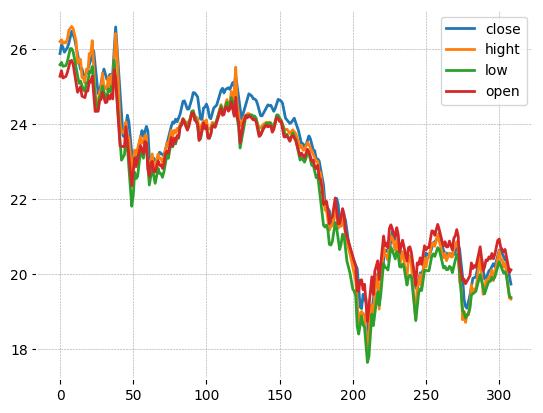

In [441]:
plt.plot(inverse_prediction_data["Close"], label = "close")
plt.plot(inverse_prediction_data["High"], label = "hight")
plt.plot(inverse_prediction_data["Low"], label = "low")
plt.plot(inverse_prediction_data["Open"], label = "open")

plt.legend()

In [442]:
from datetime import timedelta
inverse_forecast_data # 예측 데이터

def to_dataframe(inverse_prediction_data):

  new_dataframe = pd.DataFrame()

  for coin_name, value in inverse_prediction_data.items():
    print(coin_name)
    print(value.flatten())
    new_dataframe[coin_name] = value[0]

  # new_dataframe.index = timedelta(hours=1) + index_data.index[-1]
  return new_dataframe

inverse_forecast_data1 = to_dataframe(inverse_forecast_data)

Close
[19.73061]
Open
[20.109352]
High
[19.33102]
Low
[19.373995]
Volume
[268422.8]
total_transaction
[7105.352]


In [443]:
inverse_forecast_data1

,Close,Open,High,Low,Volume,total_transaction
0,19.73061,20.109352,19.33102,19.373995,268422.8125,7105.352051


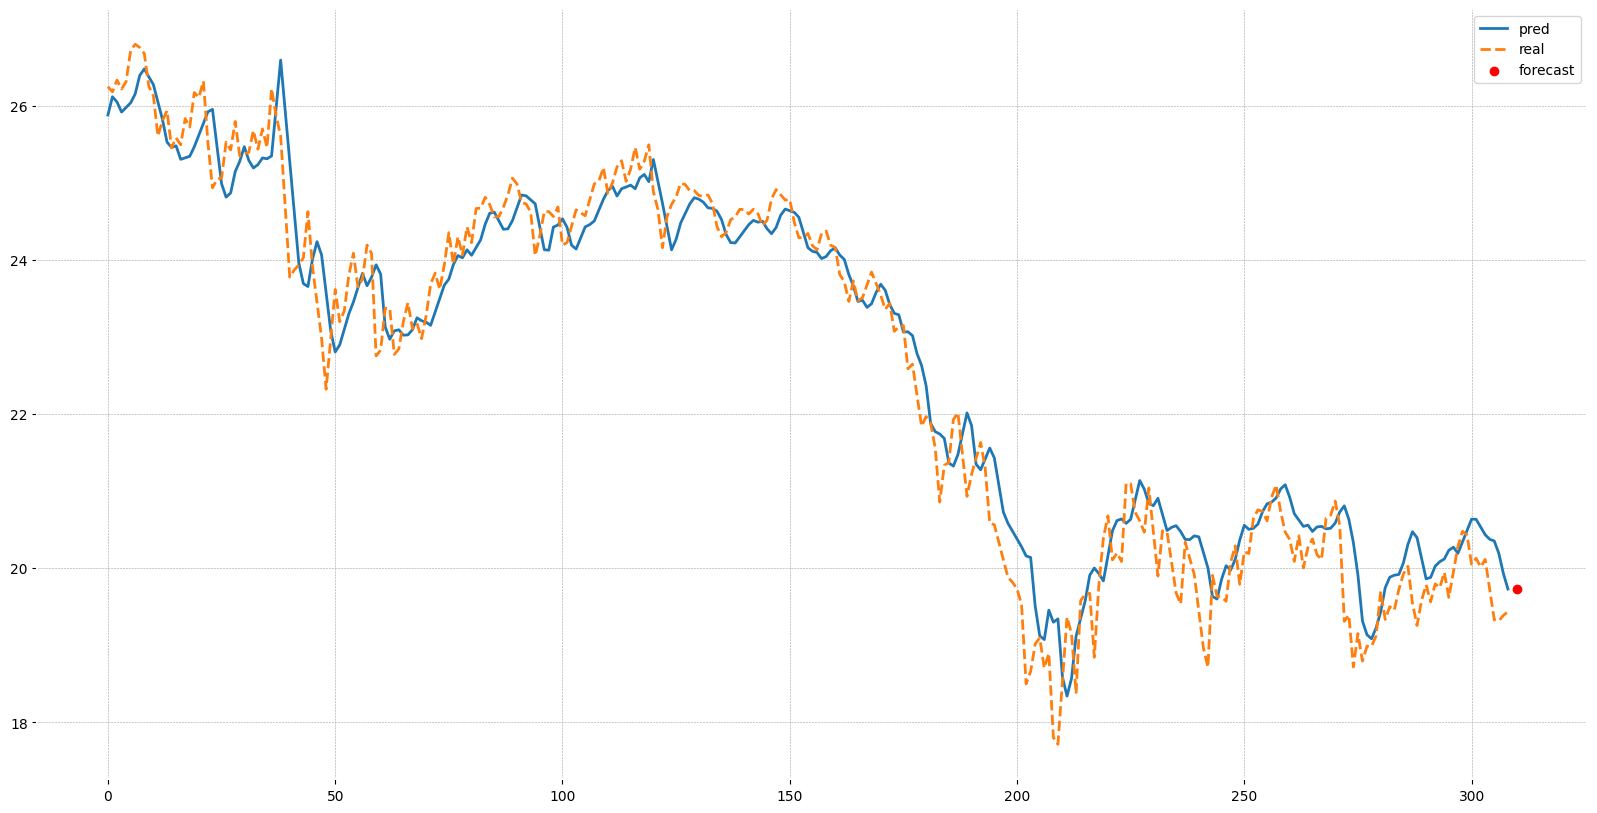

In [446]:
plt.figure(figsize=(20,10))
plt.plot(inverse_prediction_data["Close"], label = "pred")
plt.plot(df_hourly[1526+308+72:]["Close"].values, linestyle = "--", label = "real")
plt.scatter(len(inverse_prediction_data["Close"])+1, inverse_forecast_data1["Close"] , color = "red", label = "forecast")

plt.legend()

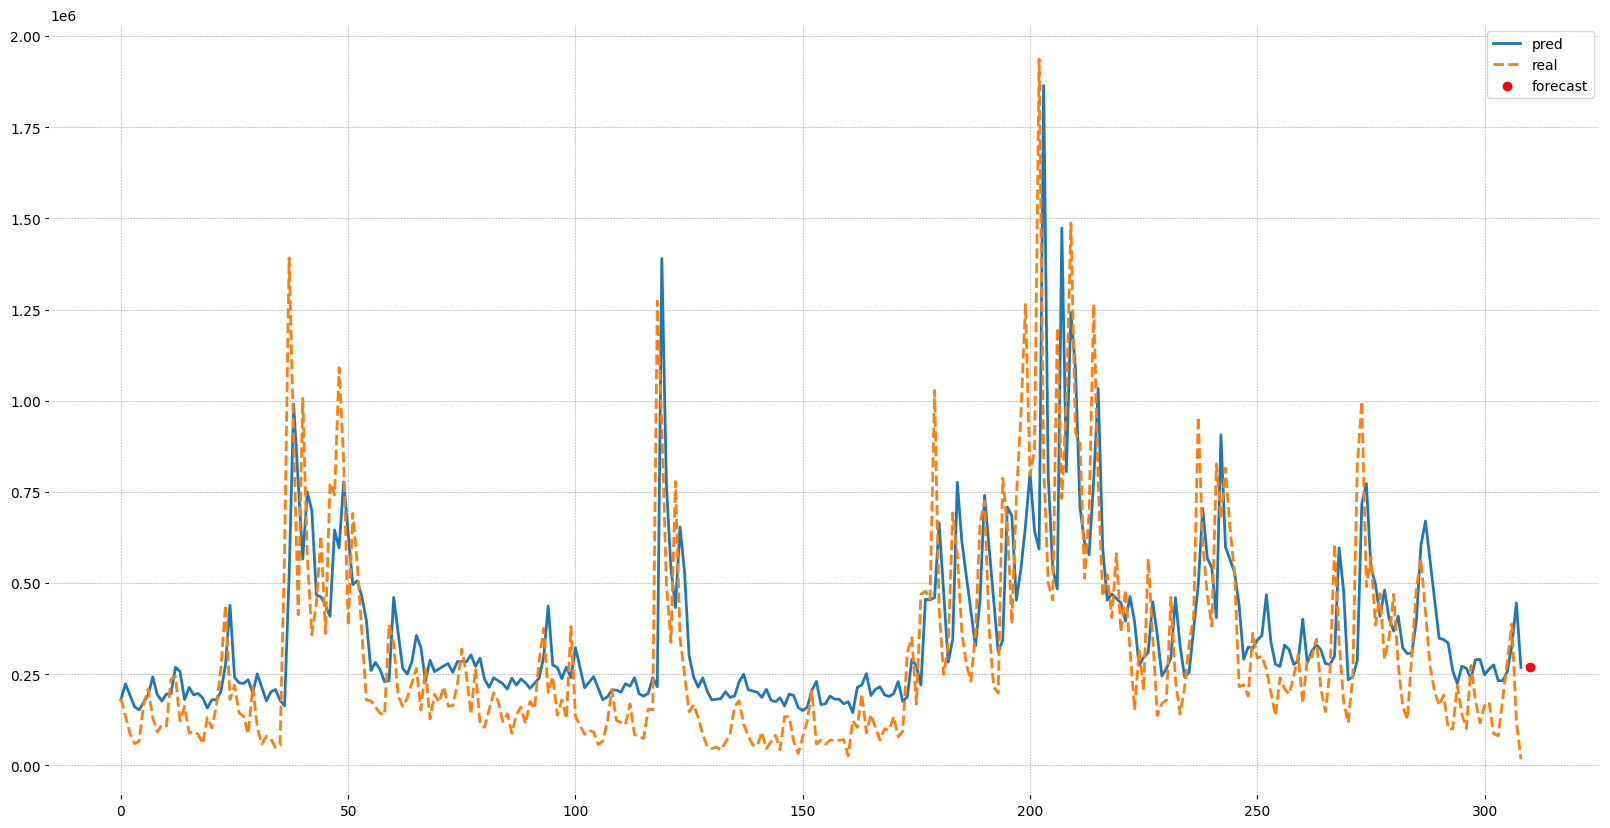

In [445]:
plt.figure(figsize=(20,10))
plt.plot(inverse_prediction_data["Volume"], label = "pred")
plt.plot(df_hourly[1526+308+72:]["Volume"].values, linestyle = "--", label = "real")
plt.scatter(len(inverse_prediction_data["Close"])+1, inverse_forecast_data1["Volume"] , color = "red", label = "forecast")

plt.legend()